## This notebook demonstrates the use of the pre-trained [Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/abs/2103.03230) model and Spotify's [Annoy](https://github.com/spotify/annoy) algorithm for finding similar vectors (images).
## I will use the STL10 (train+unlabeled) dataset.

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
import joblib
import glob, os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1
Torchvision Version:  0.9.1


# Load in the data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

stl_unlabeled = torchvision.datasets.STL10(root='./stl_data', split='train+unlabeled',
                                       download=True, transform=transform) # 105000 images
stl_unlabeledloader = torch.utils.data.DataLoader(stl_unlabeled, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # This does not make sense when shuffeling 

stl_classes = ('plane', 'bird', 'car', 'cat',
           'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

Files already downloaded and verified


# Load the model 

### Here, I score the data in batches and save the embedding for every batch (cannot have all of these in RAM) 

In [3]:
# load in the BarlowTwins model
barlowtwins_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

Using cache found in /Users/vladmarinescu/.cache/torch/hub/facebookresearch_barlowtwins_main


In [5]:
!mkdir embeddings

mkdir: embeddings: File exists


# Generating the embeddings below. This can take up to an hour 

In [4]:
index = 0 
emb = []
counter = 0
for item in tqdm(stl_unlabeledloader):
    embeddings = barlowtwins_model(item[0])
    indexes = index+np.arange(len(item[0]))
    index = index+len(item[0])
    emb.append((indexes,embeddings.detach().numpy()))
    
    if len(emb)>=1:
        joblib.dump(emb,f"embeddings/bt_{counter}.gz")
        counter+=1
        emb.clear()
        

100%|██████████| 105/105 [1:20:41<00:00, 46.11s/it]


# Fill in the AnnoyIndex 

### In this case, the angular metric is used, but [others](https://github.com/spotify/annoy) are available

In [9]:
from annoy import AnnoyIndex

ann_angular_index = AnnoyIndex(1000, 'angular') 

In [10]:
for file in tqdm(glob.glob("embeddings/*.gz")):
    batches = joblib.load(file)
    for batch in batches:
        for index, embedding in zip(*batch):
            ann_angular_index.add_item(index, embedding)

ann_angular_index.build(100) # 100 trees
ann_angular_index.save('bt_angular.ann')

            

100%|██████████| 105/105 [00:10<00:00,  9.62it/s]


True

# Reload (as for a prod app) and use the index

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# figure size in inches
rcParams['figure.figsize'] = 10,10
import numpy as np

In [93]:
def search_image(images, indexs):
    search_image_idx = indexs[0]
    
    img_stack = torch.stack([images[x][0] for x in indexs[2:]])
    response_img = torchvision.utils.make_grid(img_stack)
    
    search_img = torchvision.utils.make_grid(images[search_image_idx][0])
    
    
    search_img = search_img / 2 + 0.5     # unnormalize
    search_npimg = search_img.numpy()
    
    response_img = response_img / 2 + 0.5     # unnormalize
    response_npimg = response_img.numpy()
    
    ax1 = plt.subplot2grid((1, 6), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((1, 6), (0, 1), colspan=5)
    
    ax1.imshow(np.transpose(search_npimg, (1, 2, 0)))
    ax2.imshow(np.transpose(response_npimg, (1, 2, 0)))
    
    fig = plt.gcf()
    fig.set_size_inches(30, 30)
    
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)

    ax1.set_title('Search image', fontsize=20)
    ax2.set_title('Results', fontsize=20)
        
    plt.show()

In [150]:
idx = AnnoyIndex(1000, 'angular')
idx.load('bt_angular.ann') 

True

### Below, I picked one image from the 10 categories that are labeled in STL10 ('plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck').
### These search images are somewhat hand-picked to have a clear image of the category (some pictures of deer would be almost all grass - making it hard for humans to see).
### It is also worth noting that this dataset does contain duplicates or very similar images (slightly different cropping) as we see below. 
### To fix this, you can run the notebook with only "train" data, but searching a large space was the purpose of this example. 

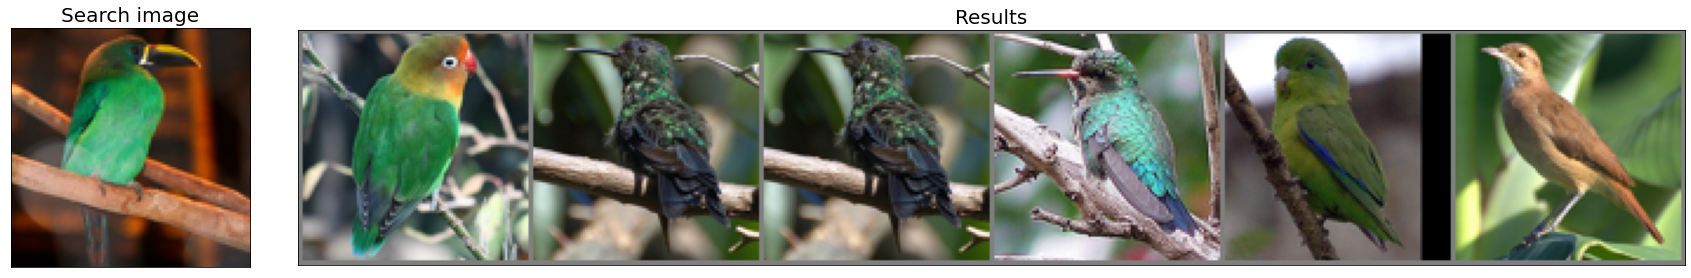

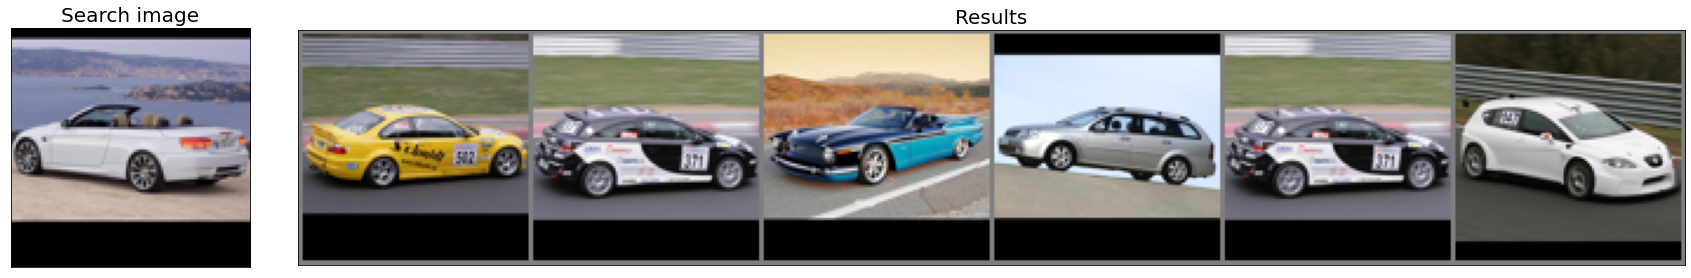

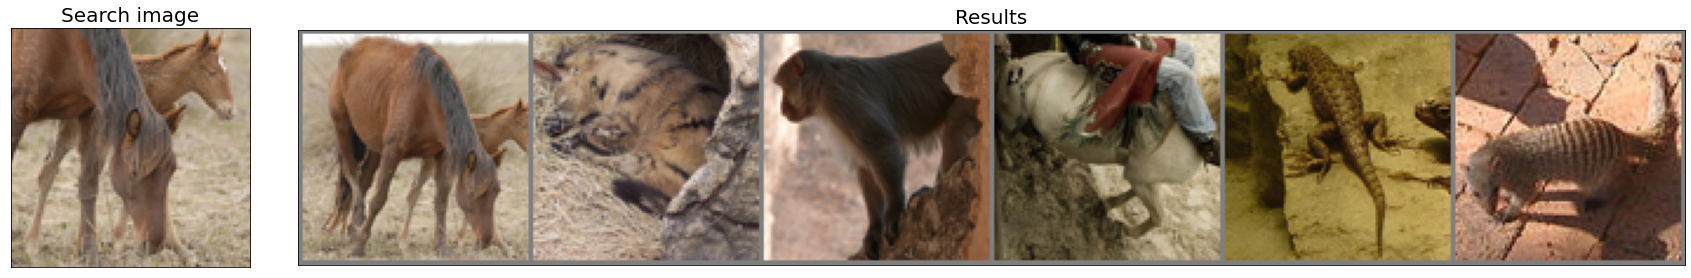

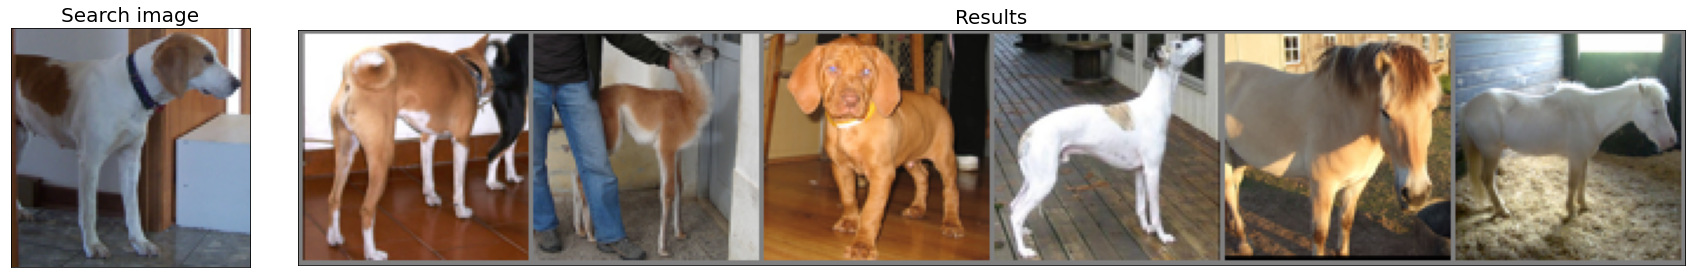

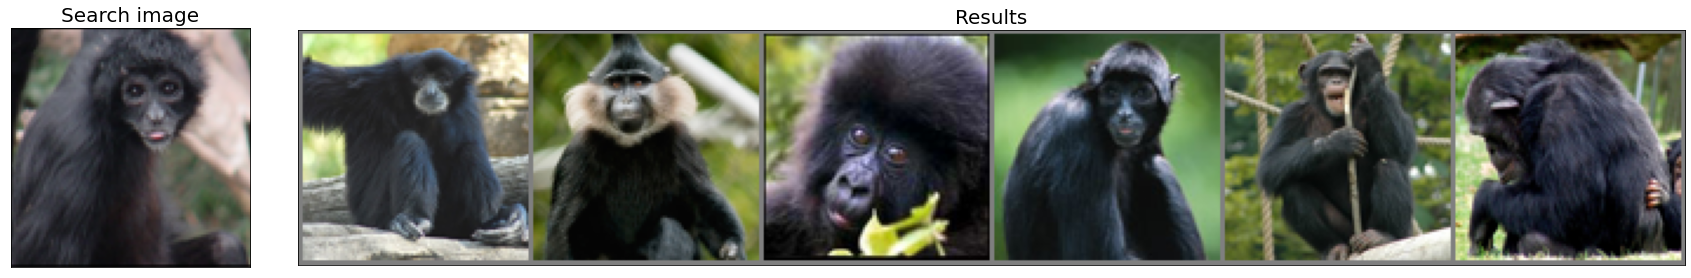

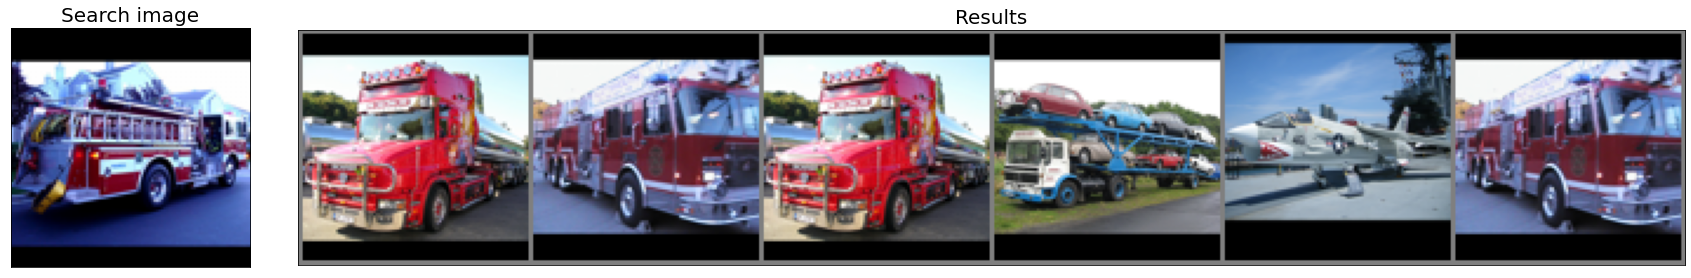

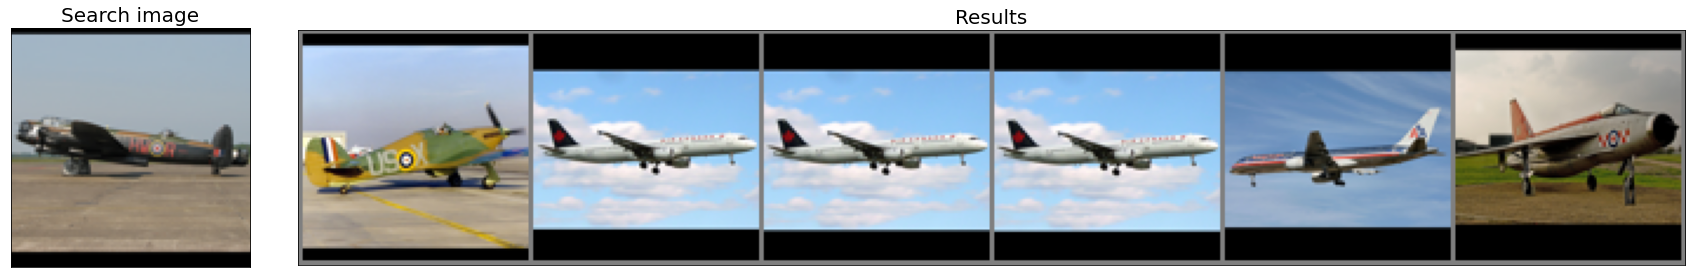

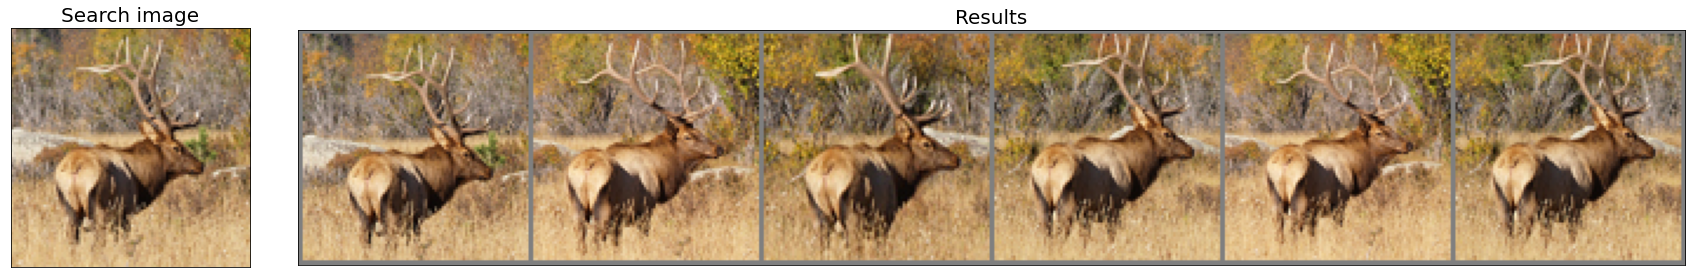

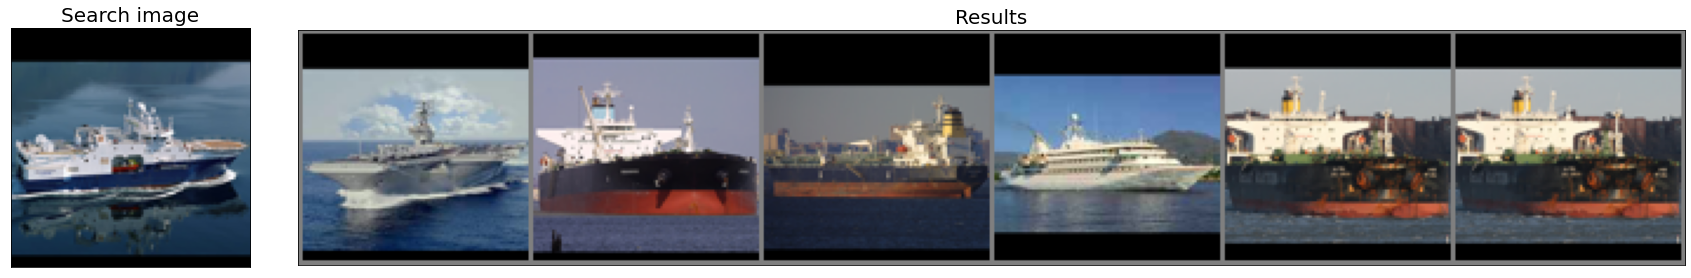

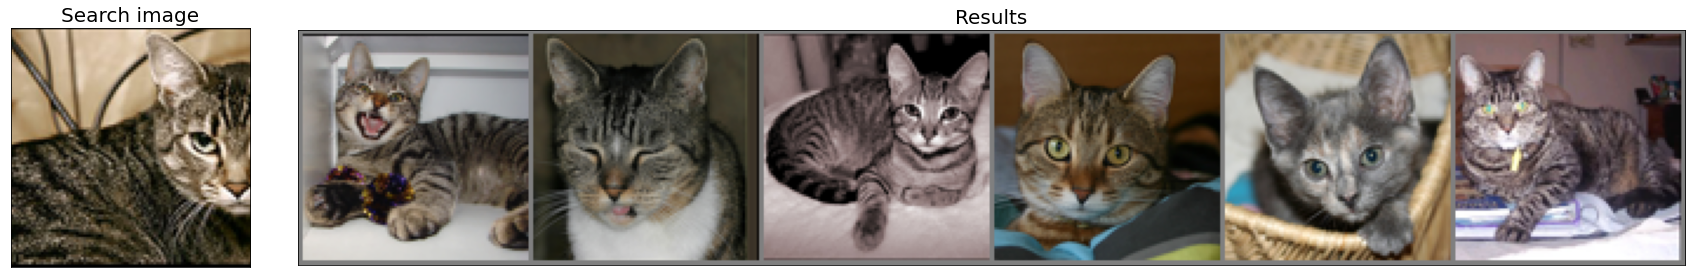

In [153]:
search_image(stl_unlabeled,idx.get_nns_by_item(27, 8)) # bird
search_image(stl_unlabeled,idx.get_nns_by_item(19, 8)) # car
search_image(stl_unlabeled,idx.get_nns_by_item(15, 8)) # horse
search_image(stl_unlabeled,idx.get_nns_by_item(26, 8)) # dog
search_image(stl_unlabeled,idx.get_nns_by_item(44, 8)) # monkey
search_image(stl_unlabeled,idx.get_nns_by_item(5, 8)) # truck
search_image(stl_unlabeled,idx.get_nns_by_item(10, 8)) # plane
search_image(stl_unlabeled,idx.get_nns_by_item(45, 8)) # deer
search_image(stl_unlabeled,idx.get_nns_by_item(9, 8)) # boat
search_image(stl_unlabeled,idx.get_nns_by_item(46, 8)) # cat

#search_image(stl_unlabeled,idx.get_nns_by_item(6, 8))
